<a href="https://colab.research.google.com/github/lqiang67/generative-models-on-toys/blob/main/energy_model_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Enery Models
We want to fit a dataset $\mathcal D = \{x_i\}_{i=1}^n$ with an energy model of form
$$
p_{\theta}(x) = \frac{\exp(f_\theta(x))}{Z_\theta}, ~~~~~~~~ Z_\theta = \int \exp(f_\theta(x)) d x,
$$
where $f_\theta(x)$ is a neural network, and $Z_\theta$ is the partition function.


## Maximum Likelihood Estimator (MLE)

We will try maximum likelihood estimator (MLE). The log-likelihood function is
$$
\ell(\theta; \mathcal D) =  \mathbb E_{x\sim \mathcal D} [\log p_\theta(x)] =  
\mathbb E_{x\sim \mathcal D} [f_\theta(x)] - \log Z_\theta.
$$
Taking the gradient:
$$
\nabla_\theta \ell(\theta; \mathcal D) =  
\mathbb E_{x\sim \mathcal D} [\nabla_\theta f_\theta(x)] - \mathbb E_{x\sim p_\theta}[\nabla_{\theta} f_\theta(x)].
$$
Assume we draw a sample $\hat{\mathcal D}_{\theta}\overset{def}{=}\{\hat x_i\}_{i=1}^n$ from $p_\theta$. The gradient can be estimated via
$$
\nabla_\theta \ell(\theta; \mathcal D)
\approx
\mathbb E_{x\sim \mathcal D} [\nabla_\theta f_\theta(x)] - \mathbb E_{\hat x \sim \hat{\mathcal D}_\theta}[\nabla_{\theta} f_\theta(\hat x)].  
$$
In practice, however, we need to find approximate ways to draw $\hat{\mathcal D_\theta}$. In the toy example below, we will try a brute force way where we partition the space on grids and draw sample on the grids. This only works for low dimensional cases.

A more general way draw approximate sample is Langevin dynamics, which simulates a Markov chain via
$$
x^{t+1} \gets x^t +\frac{\epsilon}{2} \nabla_x \log f_\theta(x^t) + \sqrt{\epsilon} \xi^t,~~~~~~~~ \xi^t\overset{iid}{\sim }\mathcal N(0, I),
$$
where $\epsilon$ is a small step size. It is expected that $x^t$ approximately follows $p_\theta$ when $t$ is large and $\epsilon$ is small.

## Contrastive Divergence (CD)
CD is an approximation of gradient descent of MLE  where the negative sample $\hat x \sim \hat{\mathcal D}_\theta$ is approximated performing on or few steps of MCMC starting from the data points. Equipped with Langevin sampler, CD updates the parameters with the following approximate gradient:
$$
\hat \nabla_\theta^{\mathrm{CD}} \ell(\theta)
= \mathbb E_{x\sim \mathcal D} [\nabla_\theta f_\theta(x) -\nabla_{\theta} f_\theta(T_{\mathrm{Langevin}}(x; \xi))],~~~~~~~ \xi \sim \mathcal N(0, I),
$$
where
$$
T_{\mathrm{Langevin}}(x; \xi) = x + \frac{\epsilon}{2} \nabla_x \log f_\theta(x) + \sqrt{\epsilon} \xi.
$$

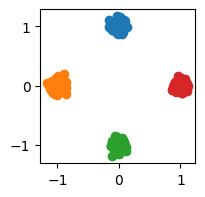

In [1]:
#@title Generate 2D GMM Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import namedtuple


DataInfo = namedtuple('data_info', ['centers', 'cluster_idx'])
def sample_circular_gmm(batch_size, num_modes=4, radius=1.0, std=0.05):
    angles = torch.linspace(0, 2 * torch.pi, num_modes+1)[:-1] + torch.pi/2
    centers = torch.stack([radius * torch.cos(angles), radius * torch.sin(angles)], dim=1)
    cluster_idx = torch.randint(0, num_modes, (batch_size,))
    selected_centers = centers[cluster_idx]
    batch_data = selected_centers + std * torch.randn(batch_size, 2)

    data_info = DataInfo(centers=centers, cluster_idx=cluster_idx)
    return batch_data, data_info

# Visualize the data
data_points, data_info = sample_circular_gmm(1000, num_modes=4)

plt.figure(figsize=(2, 2))
for i in range(len(data_info.centers)):
    idx = (data_info.cluster_idx == i)
    plt.scatter(data_points[idx, 0], data_points[idx, 1])


logZ: 6.44


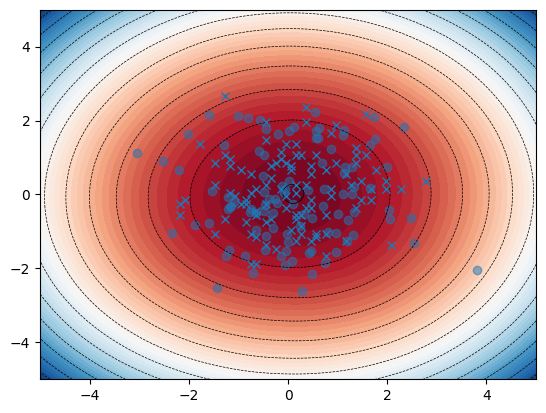

In [12]:
#@title Define Energy Model
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

class EnergyModel(nn.Module):
    def __init__(self, model, input_dim):
        super(EnergyModel, self).__init__()
        self.energy = model  #  the negative energy
        self.temperature = 1.0

        # add a learnable gaussian prior term to the energy function
        self.mean_prior = nn.Parameter(torch.zeros(input_dim))
        self.inv_std_prior = nn.Parameter(torch.ones(input_dim))
        self.energy_grid_cache = None

    def neg_log_gaussian_prior(self, x):
        return torch.sum((self.inv_std_prior[None,:]*(x-self.mean_prior[None,:]))**2/2,dim=-1, keepdim=True)

    def forward(self, x):
        # total energy = (neural energy + .5*(inv_std*(x-mu))**2)/temperature
        return (-self.energy(x) - self.neg_log_gaussian_prior(x))/self.temperature

    # Evaluate the energy model on the grid, and save it in cache (only applies to 2D)
    def update_energy_2D_grid(self, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
        input_grid = torch.stack([X.flatten(), Y.flatten()], dim=1)  # Reshape to (N, dim)
        Z = self(input_grid).reshape(X.shape)
        self.energy_grid_cache = [X,Y,Z]
        return X, Y, Z

    # calculating logZ by grid sum
    def logZ_2D_grid(self,  x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y, Z = self.update_energy_2D_grid(x_range=x_range, y_range=y_range)
        logZ = torch.logsumexp(Z.flatten(), dim=0) # correct upto a constant
        return logZ

    # log likelihood of the data using logZ_2D_grid as approximation
    def log_likelihood_2D_grid(self, data, reduction='mean', x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):

      log_likelihood = self(data) - self.logZ_2D_grid(x_range=x_range, y_range=y_range)

      if reduction == 'mean':
        return torch.mean(log_likelihood)
      elif reduction == 'sum':
        return torch.sum(log_likelihood)
      if reduction == 'none':
        return log_likelihood
      else:
        raise ValueError(f'reduction {reduction} not supported')


    # get cached energy
    def retrieve_energy_2D_grid(self, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        if self.energy_grid_cache is None:
            X,Y,Z = self.update_energy_2D_grid()
        else:
            X,Y,Z = self.energy_grid_cache
        return X, Y, Z

    # plot energy contour
    @torch.no_grad()
    def plot_energy_2D_contour(self):
        X, Y, Z = self.retrieve_energy_2D_grid()
        plt.contour(X.detach().cpu(), Y.detach().cpu(), Z.detach().cpu(), levels=14, linewidths=0.5, colors='k')
        plt.contourf(X.detach().cpu(), Y.detach().cpu(), Z.detach().cpu(), levels=50, cmap='RdBu_r')


    # sampling from the energy model on the grid (as an approximation)
    @torch.no_grad()
    def sampling_2D_grid(self, num_samples, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y, Z = self.retrieve_energy_2D_grid(x_range=x_range, y_range=y_range)
        prob = torch.softmax(Z.flatten(), dim=0)
        index = torch.multinomial(prob, num_samples=num_samples)
        return torch.stack([X.flatten()[index], Y.flatten()[index]], dim=1)

    # Langevin sampler
    def langevin_sampler(self, x0,  num_steps=100, step_size=0.01, record_traj = False):
        x = x0.detach().requires_grad_(True)  # Ensure x requires grad for sampling
        traj = [x.detach()]
        for iter in range(num_steps):
          grad_energy = torch.autograd.grad(self(x).sum(), x)[0]
          x = x + .5*step_size * grad_energy + torch.randn_like(x) * math.sqrt(2 * step_size)

          if record_traj: traj.append(x.detach())

        if record_traj:
          return x.detach(), torch.stack(traj)
        else:
          return x.detach()

    @torch.no_grad()
    def importance_sampler(self, num_samples, proposal):
        data_proposal = proposal.sample((num_samples,))
        log_wts =  energy_model.logp(data_proposal).squeeze() - proposal.log_prob(data_proposal).squeeze()
        wts = torch.softmax(log_wts[:,None],dim = 0).squeeze()
        return data_proposal.detach(), wts.detach()

mlp = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
model = EnergyModel(mlp, input_dim = 2)

model.plot_energy_2D_contour()

logZ = model.logZ_2D_grid()

print(f'logZ:{logZ: .2f}')

x0 = torch.randn((100,2))
x = model.langevin_sampler(x0,  num_steps=100, step_size=0.01).detach()
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)

x2 = model.sampling_2D_grid(100)
plt.plot(x2[:,0], x2[:,1], 'x')
plt.show()


<Figure size 640x480 with 0 Axes>

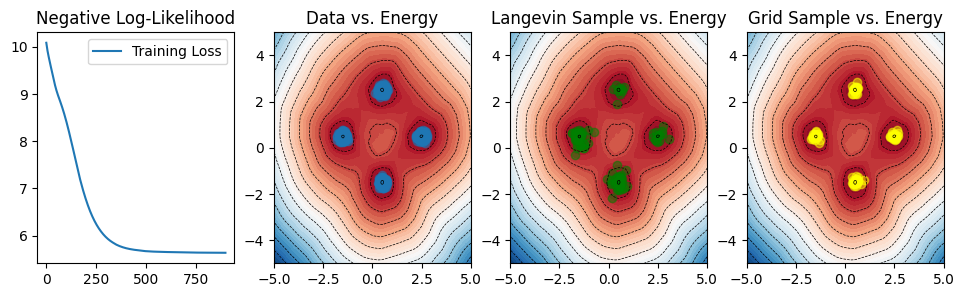

<Figure size 640x480 with 0 Axes>

In [14]:
#@title MLE Training (logZ by brute force on 2D grid)
from IPython.display import clear_output

# data
input_dim = 2
data, data_info = sample_circular_gmm(1000, num_modes=4)
data = data * 2 + .5

# model
mlp = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
energy_model = EnergyModel(mlp, input_dim)

# optimizer
batch_size = 1000
optimizer = optim.Adam(energy_model.parameters(), lr=1e-3)


loss_curve = []
for iter in range(1000):

  optimizer.zero_grad()

  data_batch = data[torch.randperm(len(data))[:batch_size]]

  x_range = torch.linspace(-5, 5, 200)
  y_range = torch.linspace(-5, 5, 200)
  loss =  - energy_model.log_likelihood_2D_grid(data_batch, x_range=x_range, y_range=y_range)

  loss.backward()

  optimizer.step()

  loss_curve.append(loss.item())

  # plot
  if iter % 100 == 0:
    clear_output(wait=True)
    KK = 10; kk=1
    plt.figure(figsize=(3*KK,3))

    plt.subplot(1,KK,kk);kk+=1
    plt.plot(loss_curve,label='Training Loss')
    plt.title('Negative Log-Likelihood')
    plt.legend()

    plt.subplot(1,KK,kk);kk+=1
    energy_model.plot_energy_2D_contour()
    plt.scatter(data_batch[:, 0], data_batch[:, 1], alpha=0.5, label='real')
    plt.title('Data vs. Energy')

    plt.subplot(1,KK,kk);kk+=1
    x0 = torch.randn((100,2))
    energy_model.temperature = 1.0
    data_langevin, traj = energy_model.langevin_sampler(x0,  num_steps=1000, step_size=0.001, record_traj = True)
    energy_model.plot_energy_2D_contour()
    plt.scatter(data_langevin[:, 0], data_langevin[:, 1], alpha=0.5, label='real', color='green')
    plt.title('Langevin Sample vs. Energy')

    plt.subplot(1,KK,kk);kk+=1
    energy_model.plot_energy_2D_contour()
    data_grid = energy_model.sampling_2D_grid(100)
    plt.scatter(data_grid[:, 0], data_grid[:, 1], alpha=0.5, label='real', color='yellow')
    plt.title('Grid Sample vs. Energy')

    plt.show()
    plt.suptitle(f'iter={iter}')


<Figure size 640x480 with 0 Axes>

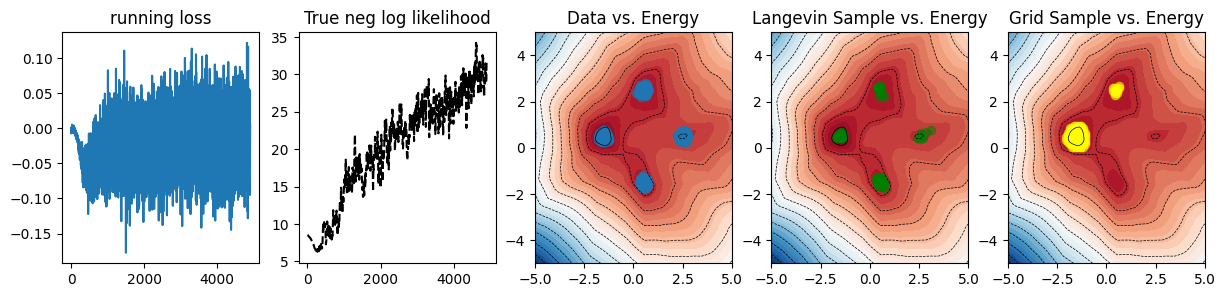

<Figure size 640x480 with 0 Axes>

In [18]:
#@title Contrastive Divergence

input_dim = 2
mlp = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
energy_model = EnergyModel(mlp,input_dim)

batch_size = 1000
optimizer = optim.Adam(energy_model.parameters(), lr=1e-3)


from IPython.display import clear_output

loss_curve = []
true_neg_log_likelihood = []
for iter in range(5000):

  optimizer.zero_grad()

  # real data
  data_real = data[torch.randperm(len(data))[:batch_size]]

  # data perturbed from data using Langevin sampler
  data_fake = energy_model.langevin_sampler(data_real, num_steps=1, step_size=0.001).detach()

  # the contrastive loss
  loss = -(energy_model(data_real).mean() - energy_model(data_fake).mean())

  loss.backward()

  optimizer.step()

  # true negative log likelihood by brute force
  true_neg_log_likelihood.append(-((torch.mean(energy_model(data_real)) - energy_model.logZ_2D_grid())).item())
  loss_curve.append(loss.item())


  # plot
  if iter % 100 == 0:
    clear_output(wait=True)
    KK = 10; kk=1
    plt.figure(figsize=(3*KK,3))

    plt.subplot(1,KK,kk);kk+=1
    plt.plot(loss_curve)
    plt.title('running loss')

    plt.subplot(1,KK,kk);kk+=1
    plt.plot(true_neg_log_likelihood, '--k')
    plt.title('True neg log likelihood')

    # plt.subplot(1,KK,kk);kk+=1
    # plt.scatter(data_real[:, 0], data_real[:, 1], alpha=0.5, label='real')
    # plt.scatter(data_fake[:, 0], data_fake[:, 1], alpha=0.5, label='perturbed')
    # plt.legend()

    plt.subplot(1,KK,kk);kk+=1
    energy_model.plot_energy_2D_contour()
    plt.scatter(data_real[:, 0], data_real[:, 1], alpha=0.5, label='real')
    plt.title('Data vs. Energy')

    plt.subplot(1,KK,kk);kk+=1
    x0 = torch.randn((100,2))
    energy_model.temperature = 1.0
    data_langevin, traj = energy_model.langevin_sampler(x0,  num_steps=1000, step_size=0.001, record_traj = True)
    energy_model.plot_energy_2D_contour()
    plt.scatter(data_langevin[:, 0], data_langevin[:, 1], alpha=0.5, label='real', color='green')
    plt.title('Langevin Sample vs. Energy')

    plt.subplot(1,KK,kk);kk+=1
    energy_model.plot_energy_2D_contour()
    data_grid = energy_model.sampling_2D_grid(100)
    plt.scatter(data_grid[:, 0], data_grid[:, 1], alpha=0.5, label='real', color='yellow')
    plt.title('Grid Sample vs. Energy')

    plt.show()
    plt.suptitle(f'iter={iter}')
